In [1]:
from dataset import *
from train import *

In [2]:
top_k_candidates = (20, 30)
k = 7
temps = [0.1, 0.3, 0.5, 0.7, 0.9]
momentums = [0.99]
k_value = 64
parameters = {'temps': temps, 'momentums': momentums}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))

for parameter in itertools.product(*parameters.values()):

    ### custom part to get parameters
    temp = parameter[0]
    momentum = parameter[1]
    ### END
    
    for images in k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k):
        train_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
        model = torchvision.models.resnet50
        model = MoCo(model, dim=512, K=k_value, T=temp, m=momentum, model_type='resnet',
                        weights=ResNet50_Weights.IMAGENET1K_V2, three_channel=True)
        device = torch.device('cuda:0')
        criterion = nn.CrossEntropyLoss().cuda(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)
        start_time = time.time()
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, criterion, optimizer, 100, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Epoch 1, Train_Loss 3.5861981377005576, Val_loss 4.505495071411133
Train_acc_top_20 0.125	Train_acc_top_30 0.1625	
Val_acc_top_20 0.12	Val_acc_top_30 0.21	
Epoch 2, Train_Loss 3.8104856252670287, Val_loss 4.128058433532715
Train_acc_top_20 0.1187	Train_acc_top_30 0.1562	
Val_acc_top_20 0.08	Val_acc_top_30 0.25	
Epoch 3, Train_Loss 3.584892201423645, Val_loss 4.015050411224365
Train_acc_top_20 0.1187	Train_acc_top_30 0.1688	
Val_acc_top_20 0.08	Val_acc_top_30 0.17	
Epoch 4, Train_Loss 3.419987511634827, Val_loss 3.8439533710479736
Train_acc_top_20 0.1187	Train_acc_top_30 0.2125	
Val_acc_top_20 0.12	Val_acc_top_30 0.21	
Epoch 5, Train_Loss 3.2424049377441406, Val_loss 4.8927788734436035
Train_acc_top_20 0.15	Train_acc_top_30 0.2625	
Val_acc_top_20 0.04	Val_acc_top_30 0.04	
Epoch 6, Train_Loss 2.9944095849990844, Val_loss 4.411735534667969
Train_acc_top_20 0.3063	Train_acc_top_30 0.375	
Val_acc_top_20 0.21	Val_acc_top_30 0.29	
Epoch 7, Train_Loss 2.7408071994781493, Val_loss 4.79279375076

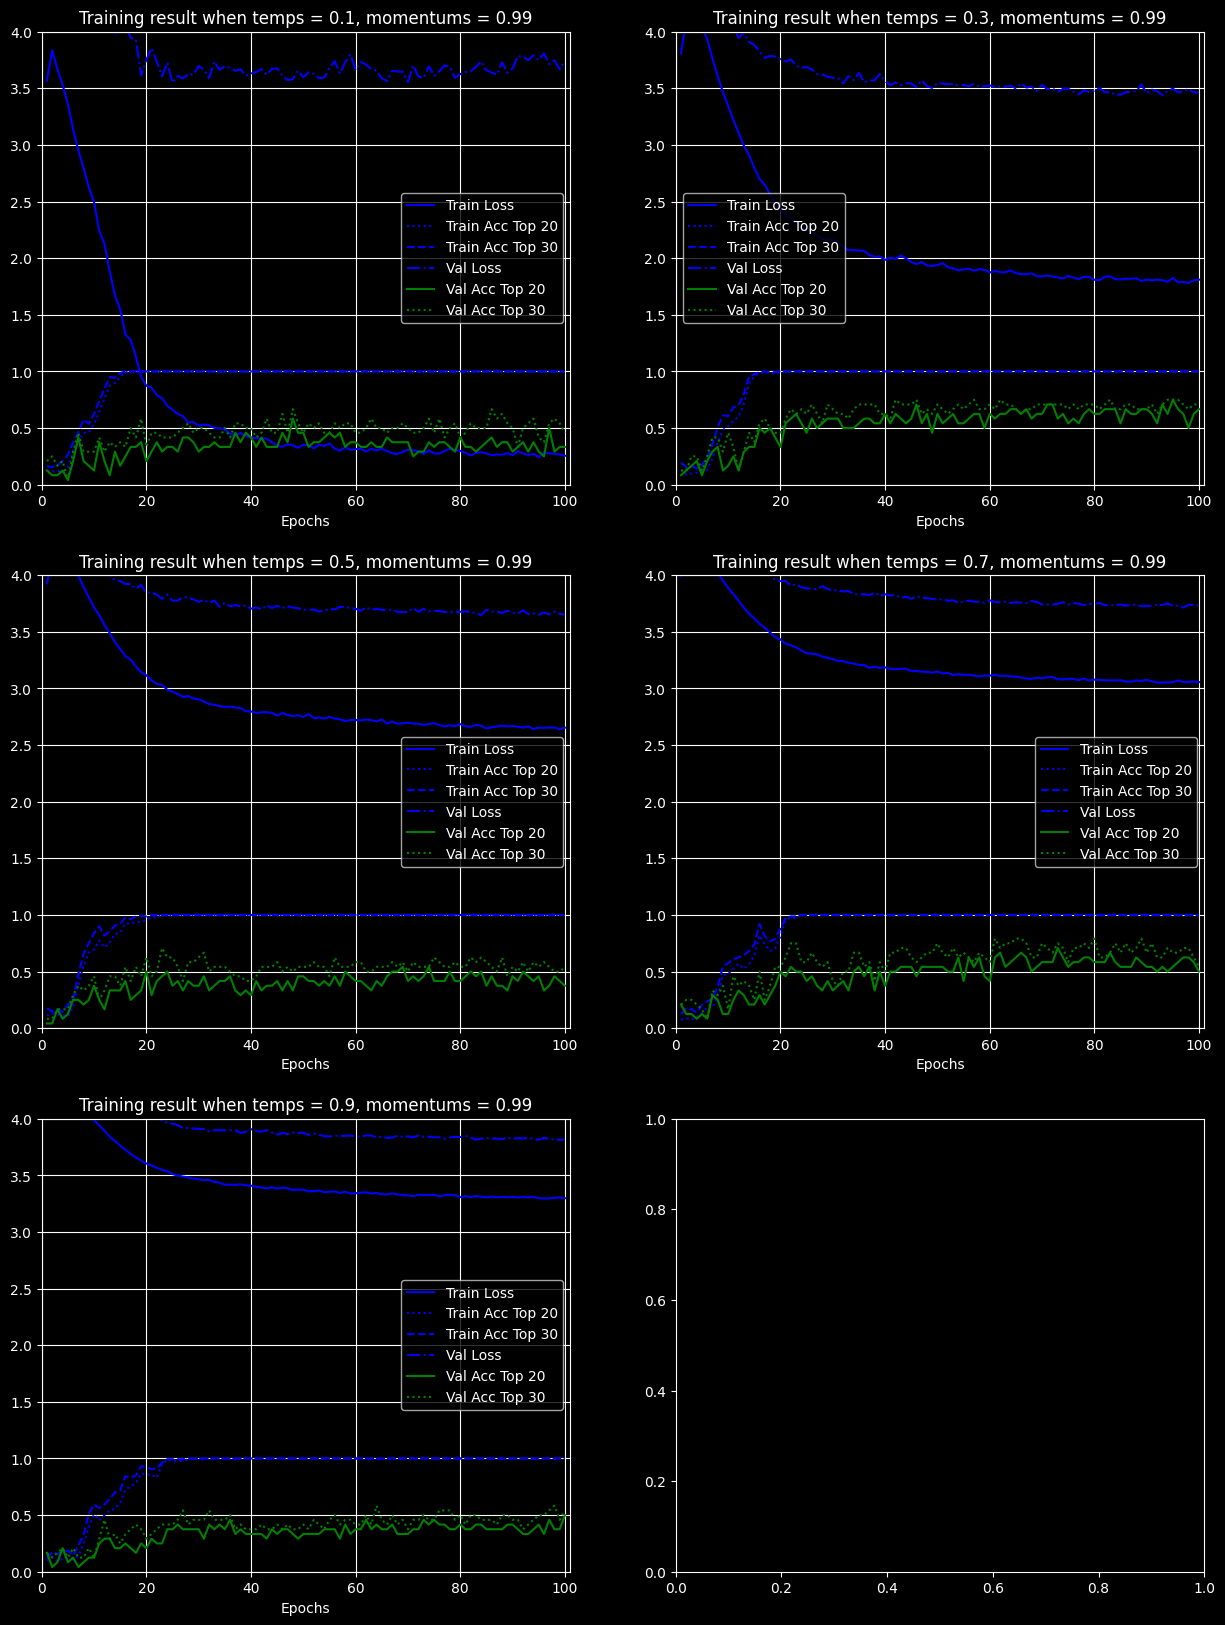

(0.1, 0.99) 20 mean 0.3375
(0.1, 0.99) 20 max 0.5833333333333334
(0.1, 0.99) 30 mean 0.4875
(0.1, 0.99) 30 max 0.6666666666666666
(0.3, 0.99) 20 mean 0.6333333333333333
(0.3, 0.99) 20 max 0.75
(0.3, 0.99) 30 mean 0.7083333333333333
(0.3, 0.99) 30 max 0.75
(0.5, 0.99) 20 mean 0.4208333333333334
(0.5, 0.99) 20 max 0.5416666666666666
(0.5, 0.99) 30 mean 0.5375000000000001
(0.5, 0.99) 30 max 0.7083333333333334
(0.7, 0.99) 20 mean 0.5541666666666666
(0.7, 0.99) 20 max 0.7083333333333334
(0.7, 0.99) 30 mean 0.6625000000000001
(0.7, 0.99) 30 max 0.7916666666666666
(0.9, 0.99) 20 mean 0.3875
(0.9, 0.99) 20 max 0.5
(0.9, 0.99) 30 mean 0.4833333333333333
(0.9, 0.99) 30 max 0.5833333333333334


In [3]:
draw_graph(train_metrics.data, 100, ('temps', 'momentums'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')